In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  !ls

Saving BBB_labels.txt to BBB_labels.txt
Saving BBB_features.csv to BBB_features.csv
User uploaded file "BBB_labels.txt" with length 6110 bytes
BBB_features.csv  BBB_labels.txt  sample_data
User uploaded file "BBB_features.csv" with length 3357142 bytes
BBB_features.csv  BBB_labels.txt  sample_data


In [2]:
import re
import numpy as np
import pandas as pd

df = pd.read_csv('BBB_features.csv', sep=';')
label = pd.read_csv('BBB_labels.txt', header=None, sep=' ')
newdf = pd.DataFrame(columns=df.columns)
logbb = []
permeate = []
for molname in df['Objects']:
    basename = re.sub(r'_c0', '', molname)
    if basename in label[0].values:
        lobBB = label[label[0] == basename][1].values[0]
        logbb.append(lobBB)
        if lobBB > 0:
            permeate.append(1)
        else:
            permeate.append(0)
        newdf = pd.concat([newdf, df[df['Objects'] == molname]])
    else:
        print('removing', molname)

df = newdf

<ipython-input-2-f75cd362ee4d>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, df[df['Objects'] == molname]])


removing 1,1,1,2-tetrachloroethane_c1
removing 1,1,1,2-tetrachloroethane_c2
removing 1,1,1,2-tetrachloroethane_c3
removing 1,1,1,2-tetrachloroethane_c4
removing 1,1,1,2-tetrachloroethane_c5
removing 1,1,1,2-tetrachloroethane_c6
removing 1,1,1,2-tetrachloroethane_c7
removing 1,1,1,2-tetrachloroethane_c8
removing 1,4-divinyloxybutane_c10
removing 1,4-divinyloxybutane_c11
removing 1,4-divinyloxybutane_c12
removing 1,4-divinyloxybutane_c13
removing 1,4-divinyloxybutane_c14
removing 1,4-divinyloxybutane_c15
removing 1,4-divinyloxybutane_c1
removing 1,4-divinyloxybutane_c2
removing 1,4-divinyloxybutane_c3
removing 1,4-divinyloxybutane_c4
removing 1,4-divinyloxybutane_c5
removing 1,4-divinyloxybutane_c6
removing 1,4-divinyloxybutane_c7
removing 1,4-divinyloxybutane_c8
removing 1,4-divinyloxybutane_c9
removing 1-butanol_c10
removing 1-butanol_c11
removing 1-butanol_c12
removing 1-butanol_c13
removing 1-butanol_c14
removing 1-butanol_c15
removing 1-butanol_c16
removing 1-butanol_c17
removing 1-

In [3]:
print('logBB', len(logbb))
print('permeate', len(permeate))
print(df.shape)

logBB 330
permeate 330
(330, 128)


In [4]:
X = df.drop(['Objects'], axis=1)
X = X.dropna(axis=1)
# remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]
# remove duplicate columns
X = X.T.drop_duplicates().T
y_regression = np.array(logbb)
y_classification = np.array(permeate)

print('X.shape', X.shape)
print('y_regression.shape', y_regression.shape)
print('y_classification.shape', y_classification.shape)

X.shape (330, 120)
y_regression.shape (330,)
y_classification.shape (330,)


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_regression_train, \
    y_regression_test, y_classification_train, \
    y_classification_test = \
    train_test_split(X, y_regression, y_classification, \
                     test_size=0.2, random_state=42)
print('X_train.shape', X_train.shape)
print('y_regression_train.shape', y_regression_train.shape)
print('y_classification_train.shape', y_classification_train.shape)
print('X_test.shape', X_test.shape)
print('y_regression_test.shape', y_regression_test.shape)
print('y_classification_test.shape', y_classification_test.shape)

ntrees = 50

X_train.shape (264, 120)
y_regression_train.shape (264,)
y_classification_train.shape (264,)
X_test.shape (66, 120)
y_regression_test.shape (66,)
y_classification_test.shape (66,)


In [6]:
import timeit

start = timeit.default_timer()
rf_regression = RandomForestRegressor(n_estimators=ntrees, random_state=42)
rf_regression.fit(X_train, y_regression_train)
y_regression_pred = rf_regression.predict(X_train)
msetrain = mean_squared_error(y_regression_train, y_regression_pred)
r2train = rf_regression.score(X_train, y_regression_train)
print('  Train R2 %5.3f'%(r2train))
print('Train MSE %8.6e'%(msetrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

  Train R2 0.946
Train MSE 2.406089e-02
Time train    0.921 s


In [7]:
msetest = mean_squared_error(y_regression_test, rf_regression.predict(X_test))
r2test = rf_regression.score(X_test, y_regression_test)
print('   Test R2 %5.3f'%(r2test))
print('  Test MSE %8.6e'%(msetest))

   Test R2 0.680
  Test MSE 1.986808e-01


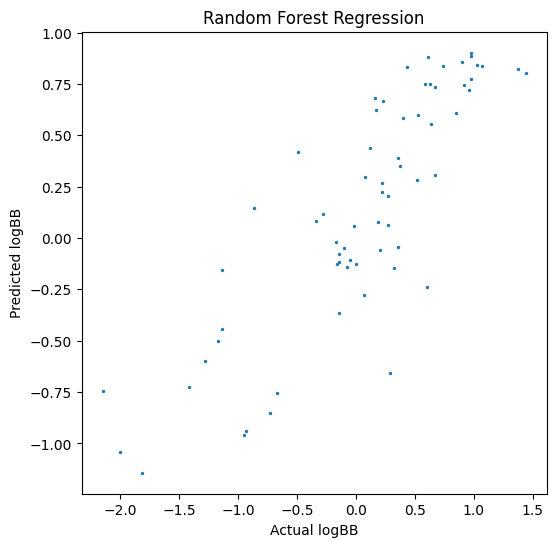

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_regression_test, rf_regression.predict(X_test), s=2)
#plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('Actual logBB')
plt.ylabel('Predicted logBB')
plt.title('Random Forest Regression')
plt.show()

In [9]:
# build a calssification RandomForrest model
start = timeit.default_timer()
rf_classification = RandomForestClassifier(n_estimators=ntrees, random_state=42)
rf_classification.fit(X_train, y_classification_train)
y_classification_pred = rf_classification.predict(X_train)
accuracytrain = accuracy_score(y_classification_train, y_classification_pred)
print('Train Accuracy %5.3f'%(accuracytrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

Train Accuracy 1.000
Time train    0.144 s


 Test Accuracy 0.864
Confusion matrix
[[21  5]
 [ 4 36]]
Feature ranking:
 1. feature  73     PSAR 0.045485
 2. feature  71      PSA 0.040046
 3. feature 104     SKIN 0.033490
 4. feature 103    CACO2 0.033462
 5. feature  74    PHSAR 0.029915
 6. feature  80     LgD9 0.026884
 7. feature  79     LgD8 0.024823
 8. feature  81    LgD10 0.023252
 9. feature  78   LgD7.5 0.021991
10. feature  41      CW6 0.021248
11. feature  69 LOGP n-Oct 0.019320
12. feature  77     LgD7 0.018925
13. feature  70 LOGP c-Hex 0.018628
14. feature 102       VD 0.016979
15. feature  37      CW2 0.014223
16. feature  36      CW1 0.012835
17. feature  42      CW7 0.012031
18. feature  43      CW8 0.011630
19. feature  48      CD1 0.011588
20. feature  58        A 0.011460
21. feature  60      POL 0.011322
22. feature 108       C3 0.010463
23. feature 116   Sdry/S 0.010357
24. feature  68      SE1 0.010172
25. feature  39      CW4 0.010107
26. feature  54      CD7 0.009863
27. feature  72      HSA 0.009644
28. 

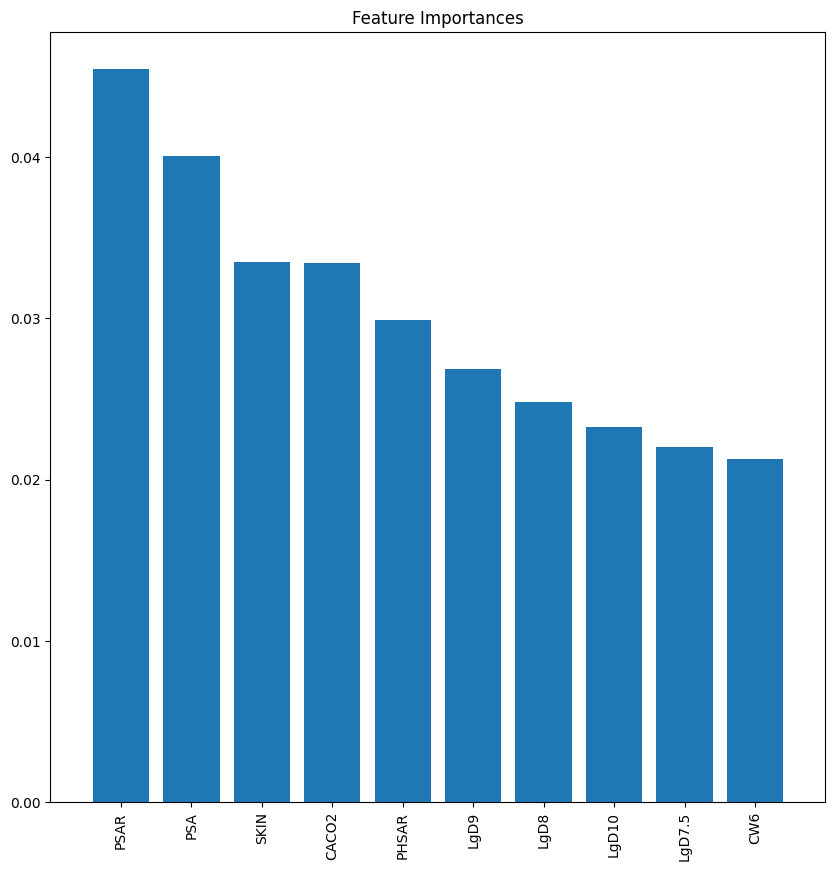

In [10]:
from sklearn.metrics import confusion_matrix

testaccuracy = accuracy_score(y_classification_test, rf_classification.predict(X_test))
print(' Test Accuracy %5.3f'%(testaccuracy))
# confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_classification_test, rf_classification.predict(X_test)))
# feature importance
# Imagine each decision tree as a flowchart for making a prediction.
# The features used higher up in the flowchart (closer to the root of
# the tree) and more frequently across all flowcharts are considered
# more important because they play a bigger role in determining the outcome.
importances = rf_classification.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%2d. feature %3d %8s %f'%(f + 1, indices[f], \
                                     X.columns[indices[f]], importances[indices[f]]))
# plot feature importance of the first 10 features
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), X.columns[indices[:10]], rotation=90)
plt.xlim([-1, 10])
plt.show()
